In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 아래는 계속 오류나서 작성해본 디버깅용 코드 (해결 완)

In [ ]:

import numpy as nphjng76
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)  # 랜덤 시드 고정

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/QI group2/dataset/Used_cars.csv', encoding="latin1")

# 데이터 확인
print("데이터셋 크기:", df.shape)
print("컬럼 목록:", df.columns)

# 타겟 인코딩할 'car_model'을 제외한 범주형 변수 찾기
categorical_features = ['car_brand', 'vehicle_type', 'gearbox', 'fuel_type', 'unrepaired_damage']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 디버깅: One-Hot Encoding 후 컬럼 확인
print("One-Hot Encoding 후 컬럼:", df.columns)


# Target Encoding (car_model 처리) - K-Fold 방식으로 데이터 누수 방지
def target_encode(train, test, target_col, n_splits=5):
    """
    K-Fold 기반 Target Encoding을 적용하여 데이터 누수를 방지하는 함수
    train: 훈련 데이터
    test: 테스트 데이터
    target_col: 인코딩할 범주형 컬럼명
    n_splits: KFold 개수 (k=5로 설정)
    """
    print(f"\n[Target Encoding 시작] 대상 컬럼: {target_col}")

    # 데이터 복사 후 인덱스 리셋
    train = train.copy().reset_index(drop=True)
    test = test.copy().reset_index(drop=True)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train[target_col + "_TE"] = np.nan  # 새로운 컬럼 생성

    # 디버깅: 데이터셋 크기 출력
    print("훈련 데이터 크기:", train.shape)
    print("테스트 데이터 크기:", test.shape)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
        print(f"\n[Fold {fold+1}]")
        print("훈련 데이터 인덱스 범위:", train_idx[:5], "...", train_idx[-5:])
        print("검증 데이터 인덱스 범위:", valid_idx[:5], "...", valid_idx[-5:])

        fold_train, fold_valid = train.iloc[train_idx], train.iloc[valid_idx]

        try:
            mean_map = fold_train.groupby(target_col)['listed_price'].mean().to_dict()
            print("Mean Map 예시 (5개):", {k: mean_map[k] for k in list(mean_map)[:5]})
        except KeyError as e:
            print("KeyError 발생 - fold_train에 해당 컬럼이 없을 가능성이 있음:", e)
            return train, test  # 오류 발생 시 원본 반환

        train.loc[valid_idx, target_col + "_TE"] = fold_valid[target_col].map(mean_map)

    # 테스트 데이터에 전체 훈련 데이터에서 계산된 평균 적용
    try:
        overall_mean = train.groupby(target_col)['listed_price'].mean().to_dict()
        print("전체 평균값 적용 예시 (5개):", {k: overall_mean[k] for k in list(overall_mean)[:5]})
    except KeyError as e:
        print("KeyError 발생 - train 데이터셋에서 target_col이 누락됨:", e)
        return train, test  # 오류 발생 시 원본 반환

    test[target_col + "_TE"] = test[target_col].map(lambda x: overall_mean.get(x, np.nan))

    return train, test


### 모델 부분 ###

# 8:2로 데이터 분할 (Train-Test Split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 디버깅: 분할 후 컬럼 확인
print("Train 데이터 컬럼:", train_df.columns)
print("Test 데이터 컬럼:", test_df.columns)

# Target Encoding 적용
train_df, test_df = target_encode(train_df, test_df, 'car_model')

# 결측값 처리
train_df['car_model_TE'].fillna(train_df['car_model_TE'].mean(), inplace=True)
test_df['car_model_TE'].fillna(train_df['car_model_TE'].mean(), inplace=True)

# car_model 원본 컬럼 삭제 (Target Encoding 완료)
train_df.drop(columns=['car_model'], inplace=True)
test_df.drop(columns=['car_model'], inplace=True)

# 특성과 타겟 변수 분리
X_train, y_train = train_df.drop(columns=['listed_price']), train_df['listed_price']
X_test, y_test = test_df.drop(columns=['listed_price']), test_df['listed_price']

# MLR 모델 학습 및 평가
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
y_pred = mlr_model.predict(X_test)

# 성능 평가 출력
print("\n모델 성능 평가")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/QI group2/dataset/Used_cars.csv'

### MLR 코드 (타겟 인코딩: car_model / 원핫 인코딩 : 나머지 범주형 변수)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)  # 랜덤 시드 고정

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/QI group2/dataset/Used_cars.csv', encoding="latin1")

# 타겟 인코딩할 'car_model'을 제외한 범주형 변수 찾기
categorical_features = ['car_brand', 'vehicle_type', 'gearbox', 'fuel_type', 'unrepaired_damage']
categorical_features_target = df.select_dtypes(include=['object']).columns.tolist()

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Target Encoding (car_model 처리) - K-Fold 방식으로 데이터 누수 방지
def target_encode(train, test, target_col, n_splits=5):
    """
    K-Fold 기반 Target Encoding을 적용하여 데이터 누수를 방지하는 함수
    train: 훈련 데이터
    test: 테스트 데이터
    target_col: 인코딩할 범주형 컬럼명
    n_splits: KFold 개수 (k=5로 설정)
    """
    train = train.copy().reset_index(drop=True)
    test = test.copy().reset_index(drop=True)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train[target_col + "_TE"] = np.nan  # 새로운 컬럼 생성

    for train_idx, valid_idx in kf.split(train):
        fold_train, fold_valid = train.iloc[train_idx], train.iloc[valid_idx]
        mean_map = fold_train.groupby(target_col)['listed_price'].mean().to_dict()
        train.loc[valid_idx, target_col + "_TE"] = fold_valid[target_col].map(mean_map)

    # 테스트 데이터에 전체 훈련 데이터에서 계산된 평균 적용
    overall_mean = train.groupby(target_col)['listed_price'].mean().to_dict()
    test[target_col + "_TE"] = test[target_col].map(lambda x: overall_mean.get(x, np.nan))

    return train, test


### 모델 부분 ###

# 8:2로 데이터 분할 (Train-Test Split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Target Encoding 적용
train_df, test_df = target_encode(train_df, test_df, 'car_model')

# 결측값 처리
train_df['car_model_TE'].fillna(train_df['car_model_TE'].mean(), inplace=True)
test_df['car_model_TE'].fillna(train_df['car_model_TE'].mean(), inplace=True)

# car_model 원본 컬럼 삭제 (Target Encoding 완료)
train_df.drop(columns=['car_model'], inplace=True)
test_df.drop(columns=['car_model'], inplace=True)

# 특성과 타겟 변수 분리
X_train, y_train = train_df.drop(columns=['listed_price']), train_df['listed_price']
X_test, y_test = test_df.drop(columns=['listed_price']), test_df['listed_price']

# MLR 모델 학습 및 평가
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
y_pred = mlr_model.predict(X_test)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE 계산

# 성능 평가 출력
print("\n모델 성능 평가")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)
print("MAPE:", mape, "%")



모델 성능 평가
MAE: 2939.881549158315
MSE: 20044286.225074157
R^2 Score: 0.7078372599305867
RMSE: 4477.084567558911
MAPE: 87.49519876634345 %


<ipython-input-2-559e2ae30480>:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['car_model_TE'].fillna(train_df['car_model_TE'].mean(), inplace=True)
<ipython-input-2-559e2ae30480>:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

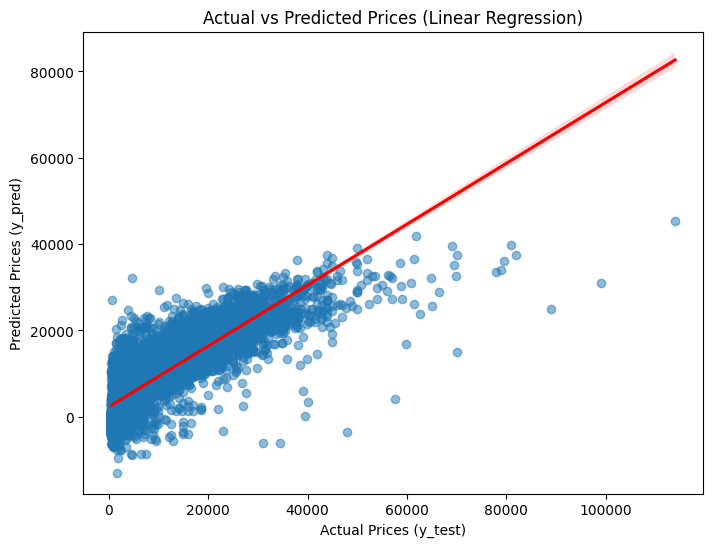

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(8, 6))

# 산점도 + 회귀선 그리기
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# 제목 및 라벨 추가
plt.xlabel("Actual Prices (y_test)")
plt.ylabel("Predicted Prices (y_pred)")
plt.title("Actual vs Predicted Prices (Linear Regression)")

# 그래프 출력
plt.show()

### MLR 코드 (원핫 인코딩 : 모든 범주형 변수)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)  # 랜덤 시드 고정

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/QI group2/dataset/Used_cars.csv', encoding="latin1")

# 범주형 변수 찾기 (car_model 포함)
categorical_features = ['car_brand', 'vehicle_type', 'gearbox', 'fuel_type', 'unrepaired_damage', 'car_model']

# One-Hot Encoding (car_model 포함)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 8:2로 데이터 분할 (Train-Test Split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 특성과 타겟 변수 분리
X_train, y_train = train_df.drop(columns=['listed_price']), train_df['listed_price']
X_test, y_test = test_df.drop(columns=['listed_price']), test_df['listed_price']

# MLR 모델 학습 및 평가
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)
y_pred = mlr_model.predict(X_test)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE 계산

# 성능 평가 출력
print("\n모델 성능 평가")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)
print("MAPE:", mape, "%")



모델 성능 평가
MAE: 2742.180146600264
MSE: 17762168.50173826
R^2 Score: 0.7411010918138454
RMSE: 4214.5187746335005
MAPE: 83.70615069605557 %


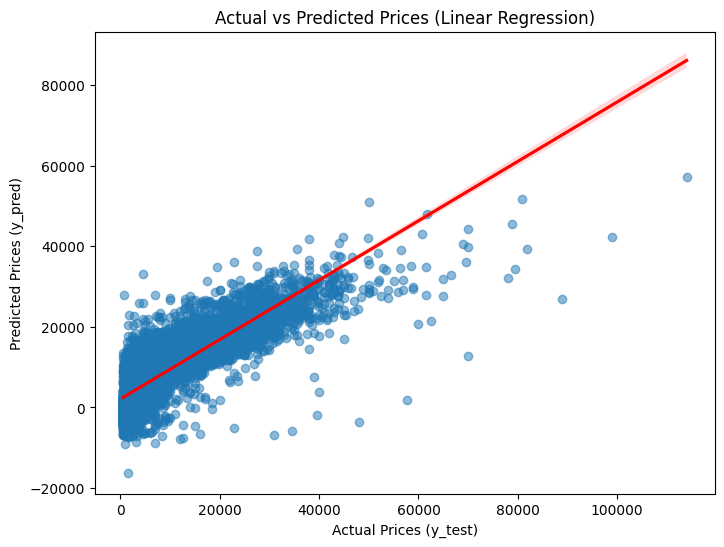

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(8, 6))

# 산점도 + 회귀선 그리기
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# 제목 및 라벨 추가
plt.xlabel("Actual Prices (y_test)")
plt.ylabel("Predicted Prices (y_pred)")
plt.title("Actual vs Predicted Prices (Linear Regression)")

# 그래프 출력
plt.show()